<a href="https://colab.research.google.com/github/fernando2393/DT2119-Final-Project/blob/Maria/best_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#!rm features.py
#!rm constants.py
#!rm load_csv_data.py
#!rm loader.py
#!ls

In [0]:
#from google.colab import files
#files.upload()

In [0]:
import loader
import load_csv_data
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [5]:
# Load original dataset
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_csv_data.get_train_val_test("/content/drive/My Drive/Datasets/spectrogram.csv")
print("There are the following classes:")
classes = set(y_train.tolist()) & set(y_val.tolist()) & set(y_test.tolist())
print(classes)

There are the following classes:
{'Hip-Hop', 'Pop', 'Experimental', 'Folk', 'Electronic', 'International', 'Instrumental', 'Rock'}


In [6]:
# Load augmented dataset (different 3s of tracks sampled)
(x_train_aug_4, y_train_aug_4), (x_val_aug_4, y_val_aug_4), (x_test_aug_4, y_test_aug_4) = load_csv_data.get_train_val_test("/content/drive/My Drive/Datasets/spectrogram_augment_4.csv")
print("There are the following classes:")
classes = set(y_train_aug_4.tolist()) & set(y_val_aug_4.tolist()) & set(y_test_aug_4.tolist())
print(classes)

There are the following classes:
{'Hip-Hop', 'Pop', 'Experimental', 'Folk', 'Electronic', 'International', 'Instrumental', 'Rock'}


In [0]:
# Load augmented dataset (time stretch, rate=0.9)
(x_train_aug_3, y_train_aug_3), (x_val_aug_3, y_val_aug_3), (x_test_aug_3, y_test_aug_3) = load_csv_data.get_train_val_test("/content/drive/My Drive/Datasets/spectrogram_augment_3.csv")

In [0]:
def conv_layer(inputs, filters, kernel_size, pool_size):
    x = Conv1D(filters, kernel_size)(inputs)
    x = tf.nn.relu(x)
    x = MaxPooling1D(pool_size=pool_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(0.2)(x)

    return x


class Classifier:

    @staticmethod
    def build(inputs, classes, layers, filters, kernel_size, pool_size):
        # Convolutional layers
        x = inputs
        for i in range(layers):
            x = conv_layer(x, filters[i], kernel_size[i], pool_size[i])
        x = tf.keras.layers.LSTM(96, return_sequences=False)(x)
        x = Dropout(0.4)(x)
        # Final layer
        x = Flatten()(x)
        x = Dense(64, kernel_regularizer=tf.keras.regularizers.l2(), activation='relu')(x)
        x = Dropout(rate=0.4, trainable=True)(x)
        outputs = Dense(classes, activation='softmax')(x)

        return tf.keras.Model(inputs=inputs, outputs=outputs)

In [0]:
def plot_history(history):

    fig, axs = plt.subplots(2)
    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    plt.show()

In [0]:
def build_model(input_shape):
  """
    model = Sequential()
    # 1st conv layer
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # 2nd conv layer
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # 3rd conv layer
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # flatten output and feed it into dense layer
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    # output layer
    model.add(Dense(8, activation='softmax'))

    return model
    """
  """  
  model = Sequential()
  model.add(Conv2D(24, (3, 3), strides=(1, 1), activation='relu', input_shape=input_shape))
  model.add(AveragePooling2D((2, 2), strides=(2,2)))
  model.add(BatchNormalization())

  model.add(Conv2D(48, (3, 3), activation='relu', padding="same"))
  model.add(AveragePooling2D((2, 2), strides=(2,2)))
  model.add(BatchNormalization())

  model.add(Conv2D(48, (3, 3), activation='relu', padding="same"))
  model.add(AveragePooling2D((2, 2), strides=(2,2)))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dropout(rate=0.5))

  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(rate=0.5))

  model.add(Dense(8))
  model.add(Activation('softmax'))
  """
  X_input = layers.Input(input_shape)

  X = layers.Conv2D(32, (5, 5), strides=(2, 2), padding = 'same', kernel_initializer='he_uniform')(X_input)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  X1 = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_uniform')(X)
  X1 = layers.BatchNormalization()(X1)

  b1 = layers.MaxPool2D((2, 2))(X) 
  b1 = layers.Conv2D(16, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
  b1 = layers.BatchNormalization()(b1)
  b1 = layers.Activation('relu')(b1)
  b1 = layers.Conv2D(128, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
  b1 = layers.BatchNormalization()(b1)

  X = layers.Add()([X1, b1])
  X = layers.Activation('relu')(X)

  X1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(X)
  X1 = layers.BatchNormalization()(X1)

  b1 = layers.Conv2D(16, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
  b1 = layers.BatchNormalization()(b1)
  b1 = layers.Activation('relu')(b1)
  b1 = layers.Conv2D(256, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
  b1 = layers.BatchNormalization()(b1)

  X = layers.Add()([X1, b1])
  X = layers.Activation('relu')(X)

  X2 = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
  X2 = layers.BatchNormalization()(X2)

  b2 = layers.MaxPool2D((2,2))(X) 
  b2 = layers.Conv2D(32, (1, 1), padding='same', kernel_initializer='he_uniform')(b2)
  b2 = layers.BatchNormalization()(b2)
  b2 = layers.Activation('relu')(b2)
  b2 = layers.Conv2D(512, (1, 1), padding='same',  kernel_initializer='he_uniform')(b2)
  b2 = layers.BatchNormalization()(b2)


  X = layers.Add()([X2, b2])
  X = layers.Activation('relu')(X)

  X2 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(X)
  X2 = layers.BatchNormalization()(X2)

  b2 = layers.Conv2D(32, (1, 1), padding='same', kernel_initializer='he_uniform')(b2)
  b2 = layers.BatchNormalization()(b2)
  b2 = layers.Activation('relu')(b2)
  b2 = layers.Conv2D(512, (1, 1), padding='same',  kernel_initializer='he_uniform')(b2)
  b2 = layers.BatchNormalization()(b2)

  X = layers.Add()([X2, b2])
  X = layers.Activation('relu')(X)

  X3 = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
  X3 = layers.BatchNormalization()(X3)

  b3 = layers.MaxPool2D((2,2))(X) 
  b3 = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_uniform')(b3)
  b3 = layers.BatchNormalization()(b3)
  b3 = layers.Activation('relu')(b3)
  b3 = layers.Conv2D(512, (1, 1), padding='same',  kernel_initializer='he_uniform')(b3)
  b3 = layers.BatchNormalization()(b3)


  X = layers.Add()([X3, b3])
  X = layers.Activation('relu')(X)

  X3 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(X)
  X3 = layers.BatchNormalization()(X3)

  b3 = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_uniform')(b3)
  b3 = layers.BatchNormalization()(b3)
  b3 = layers.Activation('relu')(b3)
  b3 = layers.Conv2D(128, (1, 1), padding='same',  kernel_initializer='he_uniform')(b3)
  b3 = layers.BatchNormalization()(b3)

  X = layers.Add()([X3, b3])
  X = layers.Activation('relu')(X)

  X = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)
  X = layers.MaxPool2D(2, 2)(X)

  X = layers.Flatten()(X)
  X = layers.Dense(128, kernel_initializer='he_uniform')(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)
  X = layers.Dense(8,kernel_initializer='he_uniform')(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('softmax')(X)

  model = tf.keras.models.Model(inputs=X_input, outputs=X, name='model_8')
  model.summary()

  return model

In [0]:
x_train = np.hstack((x_train, x_train_aug_3, x_train_aug_4))
#x_val = np.hstack((x_val, x_val_aug_4))
#x_test = np.hstack((x_test, x_test_aug_4))
y_train = np.hstack((y_train, y_train_aug_3, y_train_aug_4))
#y_val = np.hstack((y_val, y_val_aug_4))
#y_test = np.hstack((y_test, y_test_aug_4))

In [0]:
x_train = np.rollaxis(np.dstack(x_train), -1)
x_val = np.rollaxis(np.dstack(x_val), -1)
x_test = np.rollaxis(np.dstack(x_test), -1)

In [0]:
dict_labels = {'Electronic': 0, 'Experimental': 1, 'Folk': 2, 'Hip-Hop': 3,
                   'Instrumental': 4, 'International': 5, 'Pop': 6, 'Rock': 7}
y_train = [dict_labels[y_train[i]] for i in range(y_train.shape[0])]
y_val = [dict_labels[y_val[i]] for i in range(y_val.shape[0])]
y_test = [dict_labels[y_test[i]] for i in range(y_test.shape[0])]

In [0]:
y_train = to_categorical(y_train, num_classes=8)
y_val = to_categorical(y_val, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)

In [0]:
x_train = np.expand_dims(x_train, axis=3)
x_val = np.expand_dims(x_val, axis=3)
x_test = np.expand_dims(x_test, axis=3)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

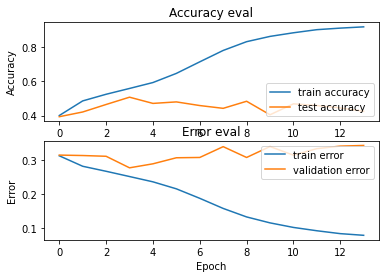

In [16]:
lr = 2e-4
epochs = 30
batch_size = 16

model = build_model((128, 128, 1))
opt = Adam(lr=lr, decay=lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

# Callbacks: early stopping and checkpoint
early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1,
                               patience=10,
                               mode='max',
                               restore_best_weights=True)

filepath = "weights.{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
callbacks_list = [early_stopping, checkpoint]
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    steps_per_epoch=len(x_train) // batch_size,
                    callbacks=callbacks_list,
                    epochs=epochs, verbose=1)


plot_history(history)

In [17]:
# Evaluate the model on the test data using `evaluate`
print("Evaluating model on test data...")
results = model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test loss:", results[0])
print("Test acc:", results[1])

Evaluating model on test data...
50/50 [==============================] - 1s 12ms/step - loss: 0.3074 - accuracy: 0.4613
Test loss: 0.3073626756668091
Test acc: 0.4612500071525574
